# Topic Modeling for Food Health Issues (NLP focus)

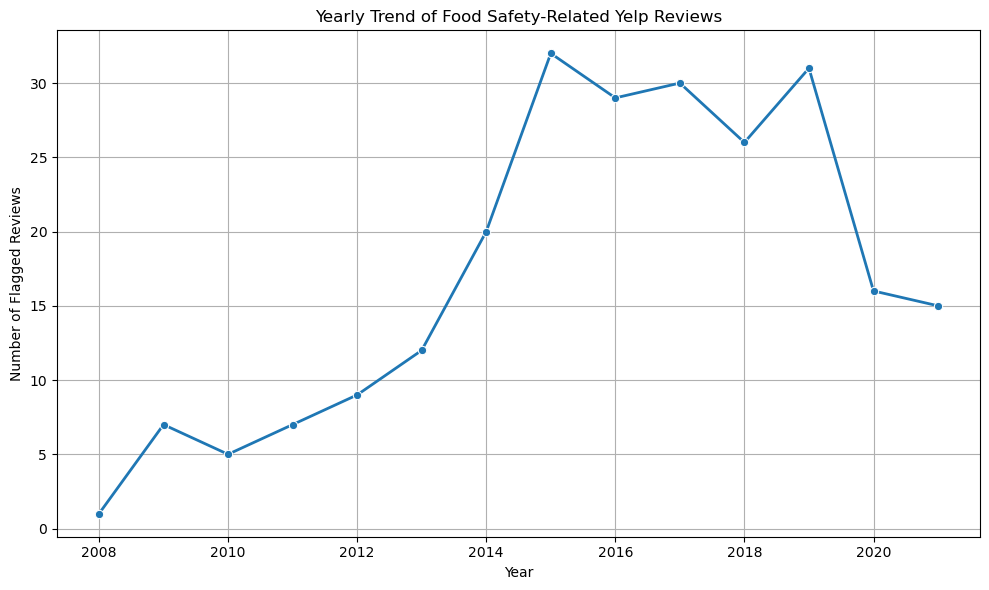

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the full dataset and keep only flagged food safety reviews
df = pd.read_csv("data/yelp_philadelphia.csv")
df = df.dropna(subset=["text", "date"])
df = df[df["food_safety_flag"] == True].copy()

# Extract year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["year"] = df["date"].dt.year

# Count flagged reviews by year
yearly_counts = df.groupby("year").size().reset_index(name="count")

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_counts, x="year", y="count", marker="o", linewidth=2)
plt.title("Yearly Trend of Food Safety-Related Yelp Reviews")
plt.xlabel("Year")
plt.ylabel("Number of Flagged Reviews")
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load dataset and filter
df = pd.read_csv("data/yelp_philadelphia.csv")
df = df.dropna(subset=["text"])
df = df[df["food_safety_flag"] == True].copy().reset_index(drop=True)

# Remove reviews that are too short
df = df[df["text"].str.split().str.len() > 10]

# Load spaCy (disable parser + ner for speed, add sentencizer for safety if needed)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Expanded stopwords for filler/vague/common terms
custom_stopwords = {
    "good", "bad", "like", "really", "great", "just", "one", "go", "got", "went",
    "come", "also", "back", "make", "say", "said", "get", "thing", "place",
    "people", "know", "even", "still", "want", "tell", "asked", "new", "old",
    "see", "told", "think", "friend", "time", "pretty", "little", "lot", "day",
    "night", "star", "try", "would", "could", "look", "sure", "need", "ever"
}

# Lemmatize and filter tokens
def preprocess(text):
    doc = nlp(text.lower())
    return " ".join([
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token.lemma_) > 2 and token.lemma_ not in custom_stopwords
    ])

# Preprocess text
df["cleaned_text"] = df["text"].apply(preprocess)

# Vectorizer with trigram support
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 3),
    max_df=0.85,
    min_df=5,
    max_features=3000
)
X = vectorizer.fit_transform(df["cleaned_text"])

# LDA Topic Modeling
n_topics = 3
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(X)

# Top n-grams per topic
def get_top_ngrams(model, feature_names, n_top=10):
    topic_keywords = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = topic.argsort()[-n_top:][::-1]
        top_words = [feature_names[i] for i in top_features]
        topic_keywords.append(top_words)
    return topic_keywords

# Display results
feature_names = vectorizer.get_feature_names_out()
topics = get_top_ngrams(lda_model, feature_names, n_top=10)

for i, words in enumerate(topics):
    print(f"\nTopic {i+1}: {', '.join(words)}")




Topic 1: hair, order, eat, ask, restaurant, drink, hair food, meal, experience, happen

Topic 2: food poisoning, poisoning, eat, sick, feel, order, hour, chicken, restaurant, taste

Topic 3: order, minute, table, service, wait, taste, dish, meal, ask, check



Topic 1: food, poisoning, food poisoning, feel, sick, eat, burger, throw, taste, end

Topic 2: eat, food, sick, food poisoning, poisoning, poisoning eat, happen, restaurant, hour, sick eat

Topic 3: hair, order, food, hair food, minute, come, table, meal, experience, wait

Topic 4: chicken, bug, food, eat, come, bug food, order, look, service, rude


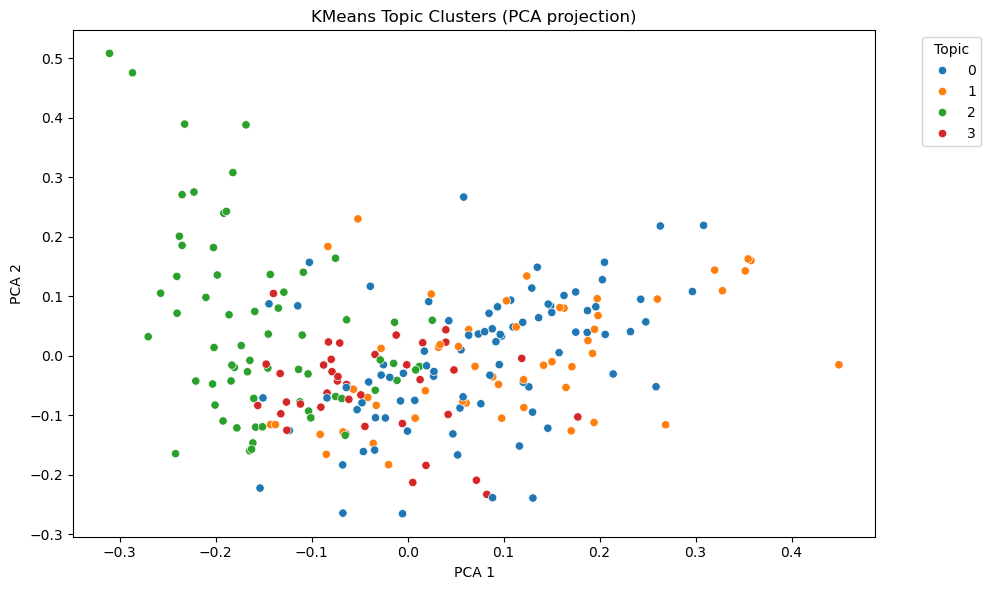

In [45]:
import pandas as pd
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (assumes food-safety flagged)
df = pd.read_csv("data/yelp_philadelphia.csv")
df = df.dropna(subset=["text"])
df = df[df["food_safety_flag"] == True].copy()

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Expand stopword list to catch vague or common filler
custom_stopwords = {
    "good", "bad", "like", "really", "great", "just", "one", "go", "got", "also",
    "back", "make", "say", "said", "get", "thing", "place", "people", "know",
    "even", "still", "want", "tell", "asked", "new", "old", "see", "told", "think",
    "friend", "time", "pretty", "little", "lot", "day", "night", "star", "try"
}

# Preprocessing function
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and token.lemma_ not in custom_stopwords
    ]
    return " ".join(tokens)

# Clean text
df["cleaned_text"] = df["text"].apply(preprocess)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.9, min_df=3, stop_words="english", ngram_range=(1, 2))
X = vectorizer.fit_transform(df["cleaned_text"])

# Fit KMeans
k = 4  # number of topics/clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Assign each doc to a cluster
df["topic"] = kmeans.labels_

# Get top terms for each cluster
def get_top_terms_per_cluster(tfidf, labels, vectorizer, top_n=10):
    df_terms = pd.DataFrame(tfidf.todense()).groupby(labels).mean()
    top_terms = []
    terms = vectorizer.get_feature_names_out()
    for i in range(df_terms.shape[0]):
        top_idx = df_terms.iloc[i].argsort()[-top_n:][::-1]
        top_words = [terms[j] for j in top_idx]
        top_terms.append(top_words)
    return top_terms

top_terms = get_top_terms_per_cluster(X, kmeans.labels_, vectorizer)

# Print topics with top terms
for i, terms in enumerate(top_terms):
    print(f"\nTopic {i + 1}: {', '.join(terms)}")

# Optional: Visualize document distribution using PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["topic"], palette="tab10")
plt.title("KMeans Topic Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


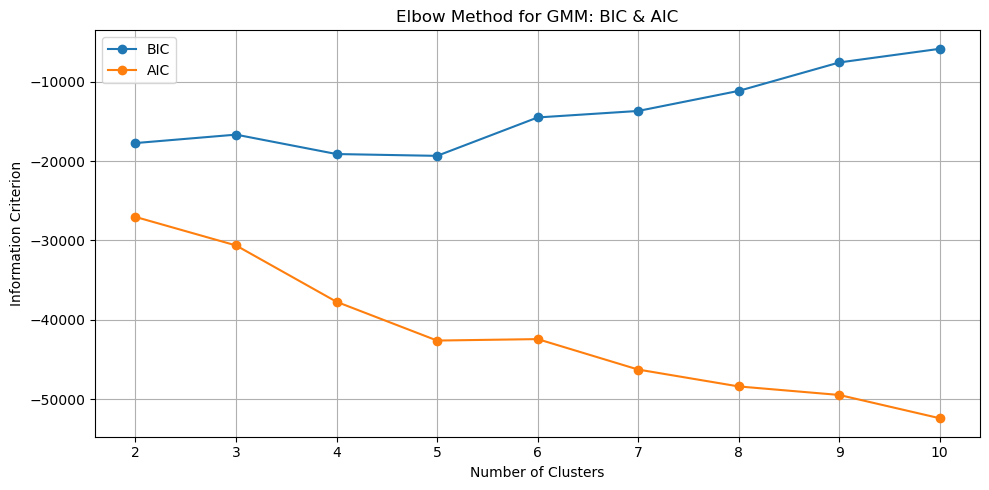

In [51]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("data/yelp_philadelphia.csv")
df = df.dropna(subset=["text"])
if "food_safety_flag" in df.columns:
    df = df[df["food_safety_flag"] == True].copy()

# Load SpaCy with sentence boundaries
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

# Define food safety terms
food_terms = {"food", "chicken", "burger", "meal", "dish", "meat", "steak", "soup", "lunch", "dinner"}
symptom_terms = {"vomit", "vomiting", "diarrhea", "sick", "nausea", "poisoning", "ill", "stomach", "pain"}
contam_terms = {"hair", "bug", "insect", "roach", "mold", "glass", "plastic", "undercooked", "raw"}

# Extract relevant sentences
sentences = []
for review in df["text"]:
    doc = nlp(review.lower())
    for sent in doc.sents:
        tokens = [tok.lemma_ for tok in sent if tok.is_alpha]
        if (
            any(t in food_terms for t in tokens) and
            (any(t in symptom_terms for t in tokens) or any(t in contam_terms for t in tokens)) and
            len(tokens) > 4
        ):
            sentences.append(sent.text.strip())

# TF-IDF vectorization + SVD
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words="english")
X = vectorizer.fit_transform(sentences)

svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)

# Elbow method using GMM BIC/AIC
n_components = list(range(2, 11))
bics = []
aics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_reduced)
    bics.append(gmm.bic(X_reduced))
    aics.append(gmm.aic(X_reduced))

# Plotting BIC and AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components, bics, label="BIC", marker='o')
plt.plot(n_components, aics, label="AIC", marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Information Criterion")
plt.title("Elbow Method for GMM: BIC & AIC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
# Refit GMM with optimal clusters
gmm = GaussianMixture(n_components=5, random_state=42)
labels = gmm.fit_predict(X_reduced)

# Add cluster labels to review dataframe
result_df = pd.DataFrame({
    "cluster": labels,
    "matched_sentence": sentences,
    "full_review": full_reviews
})

# Show sample reviews per cluster with labeled samples
for cluster_id in sorted(result_df["cluster"].unique()):
    print(f"\n🔹 Cluster {cluster_id}")
    samples = result_df[result_df["cluster"] == cluster_id].sample(3, random_state=42).reset_index(drop=True)
    for i, text in enumerate(samples["full_review"], start=1):
        print(f"Sample {i}:\n{text.strip()}\n")



🔹 Cluster 0
Sample 1:
Food poisoned and sick for 3 days

We went in for a late night meal around 11pm. The place looked interesting from the outside and we had heard it was a local favourite. 

Inside we discovered the  place was dirty. the waitress took the order and we didn't see her again. I had the turkey club sandwich (which was dry) . I ended up getting food poisoning and was sick for three days.  Never will go here again or recommend anyone else go either

Sample 2:
Food was under cooked and my husband and i both got food poisoning. Geno's cheesesteaks are the WORST. No flavor, the bread is trash,the meat is thick as hell with no seasoning- just all around the board no good. Tourists must be the only thing keeping them open, cuz they don't know anything about making cheesesteaks. Pat's across the street is not the best, but at least their food is edible & won't make you sick. Overall, waste of time and money.

Sample 3:
While the food tasted good at the time, I was violently il

In [63]:
import pandas as pd
import geopandas as gpd
import folium

# Load neighborhood shapefile
neighborhoods_gdf = gpd.read_file("shapefile/philadelphia-neighborhoods.shp")

# Copy already-filtered food safety reviews
flagged = df.copy() 

# Convert to GeoDataFrame
review_gdf = gpd.GeoDataFrame(
    flagged,
    geometry=gpd.points_from_xy(flagged.longitude, flagged.latitude),
    crs=neighborhoods_gdf.crs
)

# Spatial join with neighborhoods
flagged_with_neighborhoods = gpd.sjoin(
    review_gdf,
    neighborhoods_gdf,
    how="left",
    predicate="within"
)

# Summarize complaints by neighborhood
summary_by_area = flagged_with_neighborhoods.groupby("MAPNAME").size().reset_index(name="complaint_count")

# Merge with neighborhood polygons
neighborhoods_gdf["MAPNAME"] = neighborhoods_gdf["MAPNAME"].astype(str)
summary_by_area["MAPNAME"] = summary_by_area["MAPNAME"].astype(str)
merged = neighborhoods_gdf.merge(summary_by_area, on="MAPNAME", how="left")
merged["complaint_count"] = merged["complaint_count"].fillna(0)

# Create Folium map
philly_map = folium.Map(location=[39.9526, -75.1652], zoom_start=12, tiles="CartoDB positron")

# Add choropleth
choropleth = folium.Choropleth(
    geo_data=merged,
    name="Food Safety Complaint Rate",
    data=merged,
    columns=["MAPNAME", "complaint_count"],
    key_on="feature.properties.MAPNAME",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.4,
    nan_fill_color="white",
    legend_name="Food Safety Complaints"
).add_to(philly_map)

# Add tooltips
folium.GeoJsonTooltip(
    fields=["MAPNAME", "complaint_count"],
    aliases=["Neighborhood", "Complaints"],
    sticky=True
).add_to(choropleth.geojson)

# Add markers for individual flagged reviews
for _, row in flagged.iterrows():
    if pd.notnull(row["latitude"]) and pd.notnull(row["longitude"]):
        star_rating = row.get("stars", 0)
        color = "red" if star_rating <= 2 else "orange"
        review_date = row.get("date", "Date unavailable")
        popup_text = f"""
        <b>{row.get('name', 'Unknown')}</b><br>
        ZIP: {row.get('postal_code', 'N/A')}<br>
        ⭐ {star_rating}<br>
        🗓️ {review_date}<br>
        <i>{row.get('text', '')[:300]}</i>
        """
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=folium.Popup(popup_text, max_width=350),
            icon=folium.Icon(color=color, icon="exclamation-sign")
        ).add_to(philly_map)

# Display the map inline
philly_map
